# Machine Learning Course Project
## Identifying User Stance On Social Media via Semi-Supervised Learning

### Overview

#### Midsem Pipeline - 

 - **Read Data**: Read text files to load all the words. 
 - **Clean Data**: Remove stop-words, everything lowercase, dehashify hashtags.
 - **Format Data**: Create data in a format required by each baseline method. 
 - **Baseline Approaches**: LSA, pLSA, Para2Vec, LDA Topic Modelling. The goal of these approaches is to create a "FIXED SIZE" and "HIGH LEVEL" feature representation for variable length tweets. These representations leverage our unlabelled data. 
 - **Training**: Some Supervised Learning on the learned representation using the given labels. 
 - **Evaluation**: Compare the different methods mentioned above on different datasets. 

#### Endsem Approaches - 
 - LDA2Vec - https://www.datacamp.com/community/tutorials/lda2vec-topic-model
 - Gaussian LDA - https://rajarshd.github.io/papers/acl2015.pdf
 - Word Embeddings Informed Topic Models - http://proceedings.mlr.press/v77/zhao17a/zhao17a.pdf
 
#### Reference
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Constants

In [1]:
PATH_LABELLED_DATA_TRUMP = "../semeval2016-task6-domaincorpus/data-all-annotations/testdata-taskB-all-annotations.txt"
PATH_UNLABELLED_DATA_TRUMP = "./../semeval2016-task6-domaincorpus/downloaded_Donald_Trump.txt"

## Setup

In [2]:
# SETUP
# # Run in python console
# import nltk; nltk.download('stopwords')

# # Run in terminal or command prompt
# !python -m spacy download en

In [3]:
# !pip install gensim
# !pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['via'])

### Read Sem-Eval Task A Data (Labelled)

Interactive Visualization - http://www.saifmohammad.com/WebPages/StanceDataset.htm

Targets - 
 - Hilary Clinton
 - Atheism
 - Climate Change
 - Donald Trump
 - Feminism
 - Abortion

In [7]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

data_labelled_train = pd.concat([X_train, y_train], ignore_index=True, axis=1)
data_labelled_train.columns = ['Tweet', 'Stance']
data_labelled_test = pd.concat([X_test, y_test], ignore_index=True, axis=1)
data_labelled_test.columns = ['Tweet', 'Stance']

### Remove Symbols

In [6]:
def clean_tweets(sent):
    sent = str(sent)
    
    # Remove new line characters
    sent = re.sub('\s+', ' ', sent)

    # Remove distracting single quotes
    sent = re.sub("\'", "", sent)

    # Remove distracting single quotes
    sent = re.sub("\"", "", sent)

    # Remove hashtags
    sent = re.sub("\#", "", sent)

    # Remove http:// links
    sent = re.sub('http:\/\/.*','', sent)

    # Remove https:// links
    sent = re.sub('https:\/\/.*','', sent)
        
    return sent
    

#### Data Stats

In [8]:
data_labelled_train.where(data_labelled_train.Stance == 'AGAINST').count()

Tweet     211
Stance    211
dtype: int64

In [9]:
data_labelled_train.where(data_labelled_train.Stance == 'NONE').count()

Tweet     209
Stance    209
dtype: int64

In [10]:
data_labelled_train.where(data_labelled_train.Stance == 'FAVOR').count()

Tweet     207
Stance    207
dtype: int64

In [11]:
data_labelled_test.where(data_labelled_test.Stance == 'AGAINST').count()

Tweet     88
Stance    88
dtype: int64

In [12]:
data_labelled_test.where(data_labelled_test.Stance == 'NONE').count()

Tweet     90
Stance    90
dtype: int64

In [13]:
data_labelled_test.where(data_labelled_test.Stance == 'FAVOR').count()

Tweet     92
Stance    92
dtype: int64

### Read Sem-Eval Task B Data (Unlabelled)

In [14]:
data_unlabelled = pd.read_csv(PATH_UNLABELLED_DATA_TRUMP, sep='\t', lineterminator='\n', encoding ='latin1', names = ["ID", "Tweet"])
data_unlabelled = data_unlabelled.where(data_unlabelled.Tweet != 'Not Available')
data_unlabelled.dropna(how='any', inplace=True)
data_unlabelled['Tweet'] = data_unlabelled['Tweet'].apply(lambda x: x[1:])
data_unlabelled['Tweet'] = data_unlabelled['Tweet'].apply(clean_tweets)

In [15]:
combined_data = pd.concat([data_labelled_test, data_labelled_train, data_unlabelled], ignore_index=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [16]:
combined_data.count()

ID        53616
Stance      897
Tweet     54513
dtype: int64

In [17]:
combined_data.head(10)

,ID,Stance,Tweet
0,NaN,AGAINST,delusional - adjective 1. having false or unre...
1,NaN,AGAINST,He doesnt care & would have to give up TV gigs...
2,NaN,NONE,@mtngma @Crossbearer1956 @CarmineZozzora arent...
3,NaN,AGAINST,Im voting for Donald Trump ! SemST
4,NaN,FAVOR,@realDonaldTrump keep it up Mr Trump-when the ...
5,NaN,NONE,@ophidianpilot @NewAmericanMag All the Congres...
6,NaN,FAVOR,We need Obama out and @realDonaldTrump in the ...
7,NaN,NONE,@ThePimpernelX @Cameron_Gray @CalebHowe Totall...
8,NaN,NONE,@exjon @bjcowan1970 AMERICAN companies wont ma...
9,NaN,FAVOR,just want to give a big shoutout to my 1 man t...


In [18]:
df = combined_data['Tweet']
# df = data_labelled['Tweet']

In [19]:
data = df.values.tolist()
pprint(data[:1])

['delusional - adjective 1. having false or unrealistic beliefs or opinions 2. '
 'Donald Trump presidentialelection2016 SemST']


### Sentences To Words

In [20]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['delusional',
  'adjective',
  'having',
  'false',
  'or',
  'unrealistic',
  'beliefs',
  'or',
  'opinions',
  'donald',
  'trump',
  'semst']]


### Create Bi-Grams Tri-Grams

In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['delusional', 'adjective', 'having', 'false', 'or', 'unrealistic', 'beliefs', 'or', 'opinions', 'donald', 'trump', 'semst']


### Remove Stop Words and Lemmatize

WE NEED PRONOUNS FOR STANCE

In [22]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON'])

print(data_lemmatized[:1]), print(len(data_lemmatized))

[['delusional', 'adjective', 'false', 'unrealistic', 'belief', 'opinion', 'donald', 'trump', 'semst']]
54513


(None, None)

## Format Data

In [24]:
# Create Corpus
texts = data_lemmatized

def read_corpus(texts, tokens_only=False):
    for i, line in enumerate(texts):
        if tokens_only:
            yield line
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(line, [i])

corpus = list(read_corpus(texts))

In [25]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [26]:
train_corpus = corpus[270:]
model.build_vocab(train_corpus)
print(model.corpus_count)

54243


In [27]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 1min 14s, sys: 18.2 s, total: 1min 33s
Wall time: 1min 1s


## Evaluation

In [28]:
labelled_corpus = corpus[:897]

### Create Dataset for Supervised Learning

In [29]:
mallet_feats = []

for i in range(len(labelled_corpus)):
    representation = model.infer_vector(labelled_corpus[i].words)
    mallet_feats.append(representation)

In [30]:
STANCES = ['AGAINST', 'FAVOR', 'NONE']

In [31]:
def transform_labels(label):
    if label == 'AGAINST':
        return 0
    elif label == 'FAVOR':
        return 1
    elif label == 'NONE':
        return 2

In [32]:
# labelled_stance = combined_data.Stance[53616:54323]
labelled_stance = pd.concat([data_labelled_test['Stance'], data_labelled_train['Stance']]) 
labelled_stance = labelled_stance.apply(transform_labels)
labelled_stance = labelled_stance.tolist()

In [33]:
len(mallet_feats[0]), len(mallet_feats)

(50, 897)

## Supervised Learning

In [42]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import argparse
from sklearn.utils.multiclass import unique_labels

In [35]:
## Create Train Test Split
X_train = mallet_feats[270:]
X_test = mallet_feats[:270]
y_train = labelled_stance[270:]
y_test = labelled_stance[:270]

In [36]:
len(y_test)

270

In [37]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [38]:
def RandomForest(X_train, X_test, y_train, y_test):
    
    # GRID SEARCH
    parameters = {'n_estimators':range(100,600,100), 'max_depth':range(1,20,5)}
    rlf = RandomForestClassifier(random_state=0)
    rlf = GridSearchCV(rlf, parameters, cv=5)
    rlf.fit(X_train, y_train)
    
    y_pred = rlf.predict(X_test)

    rf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    rf_cv = cross_val_score(rlf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["RF_cross_val_score"] = rf_cv.tolist()
    report["RF_mean_acc"] = rf_cv.mean()
    report["RF_std_acc"] = rf_cv.std()*2
    report["RF_best_estimator"] = rlf.best_estimator_
    
    report["RF_CM"] = rf_cm.tolist()
    
    f1_macro = f1_score(y_test, y_pred, average='macro') 
    report["RF_F1_SCORE"] = f1_macro

    
    return report

In [39]:
def SVMClassifier(X_train, X_test, y_train, y_test):

    parameters = {'kernel':['linear','rbf','poly'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    clf = svm.SVC(gamma='auto')
    clf = GridSearchCV(clf, parameters, cv=5)
    clf.fit(X_train, y_train)
    
    clf_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["SVM_cross_val_score"] = clf_cv.tolist()
    report["SVM_mean_acc"] = clf_cv.mean()
    report["SVM_std_acc"] = clf_cv.std()*2
    report["SVM_best_estimator"] = clf.best_estimator_

    
    y_pred = clf.predict(X_test)

    clf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    report["SVM_CM"] = clf_cm.tolist()
    
    f1_macro = f1_score(y_test, y_pred, average='macro') 
    report["SVM_F1_SCORE"] = f1_macro

    
    return report
    

Confusion matrix, without normalization
[[69  3 16]
 [10 79  3]
 [15  4 71]]
{'RF_cross_val_score': [0.7782001907458559, 0.714555816654512, 0.7778611241339792, 0.7483324602758863, 0.7826475606803998], 'RF_mean_acc': 0.7603194304981267, 'RF_std_acc': 0.05187657511612562, 'RF_best_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False), 'RF_CM': [[69, 3, 16], [10, 79, 3], [15, 4, 71]], 'RF_F1_SCORE': 0.8115903655229498}


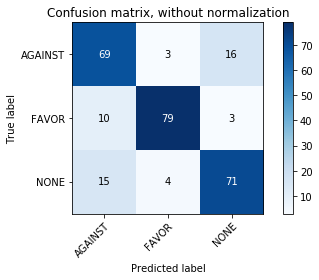

In [43]:
mallet_report = RandomForest(X_train, X_test, y_train, y_test)
print(mallet_report)

Confusion matrix, without normalization
[[68  7 13]
 [10 78  4]
 [15  7 68]]
{'SVM_cross_val_score': [0.8023946360153257, 0.7546649552729504, 0.7462024876659022, 0.7371077888519749, 0.8304908404617587], 'SVM_mean_acc': 0.7741721416535824, 'SVM_std_acc': 0.07213821809125037, 'SVM_best_estimator': SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'SVM_CM': [[68, 7, 13], [10, 78, 4], [15, 7, 68]], 'SVM_F1_SCORE': 0.7921167198563307}


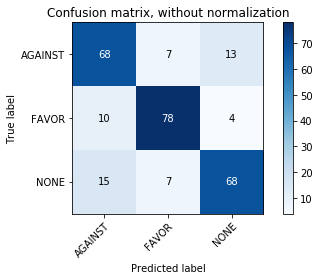

In [44]:
mallet_report = SVMClassifier(X_train, X_test, y_train, y_test)
print(mallet_report)